In [1]:
# libraries importing
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.preprocessing import MinMaxScaler
import numpy as np

from tensorflow import keras
from keras.models import Model, load_model
from keras.layers import Input, Dense, LSTM, GRU, RepeatVector, TimeDistributed
from keras.callbacks import EarlyStopping

import metrics as metric
from tqdm import tqdm 

c:\Users\gioel\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
c:\Users\gioel\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\.libs\libopenblas.EL2C6PLE4ZYW3ECEVIV3OXXGRN2NRFM2.gfortran-win_amd64.dll
c:\Users\gioel\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\.libs\libopenblas.FB5AE2TYXYH2IJRDKGDGQ3XBKLKTF43H.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


In [2]:
all_files=[]
file_name=[]
import os
for root, dirs, files in os.walk("./data/"):
    for file in files:
        if file.endswith(".csv"):
             all_files.append(os.path.join(root, file))
             file_name.append(f'{root}/{file}')

# datasets with anomalies loading
list_of_df = [pd.read_csv(file, 
                          sep=';', 
                          index_col='datetime', 
                          parse_dates=True) for file in all_files if 'anomaly-free' not in file ]

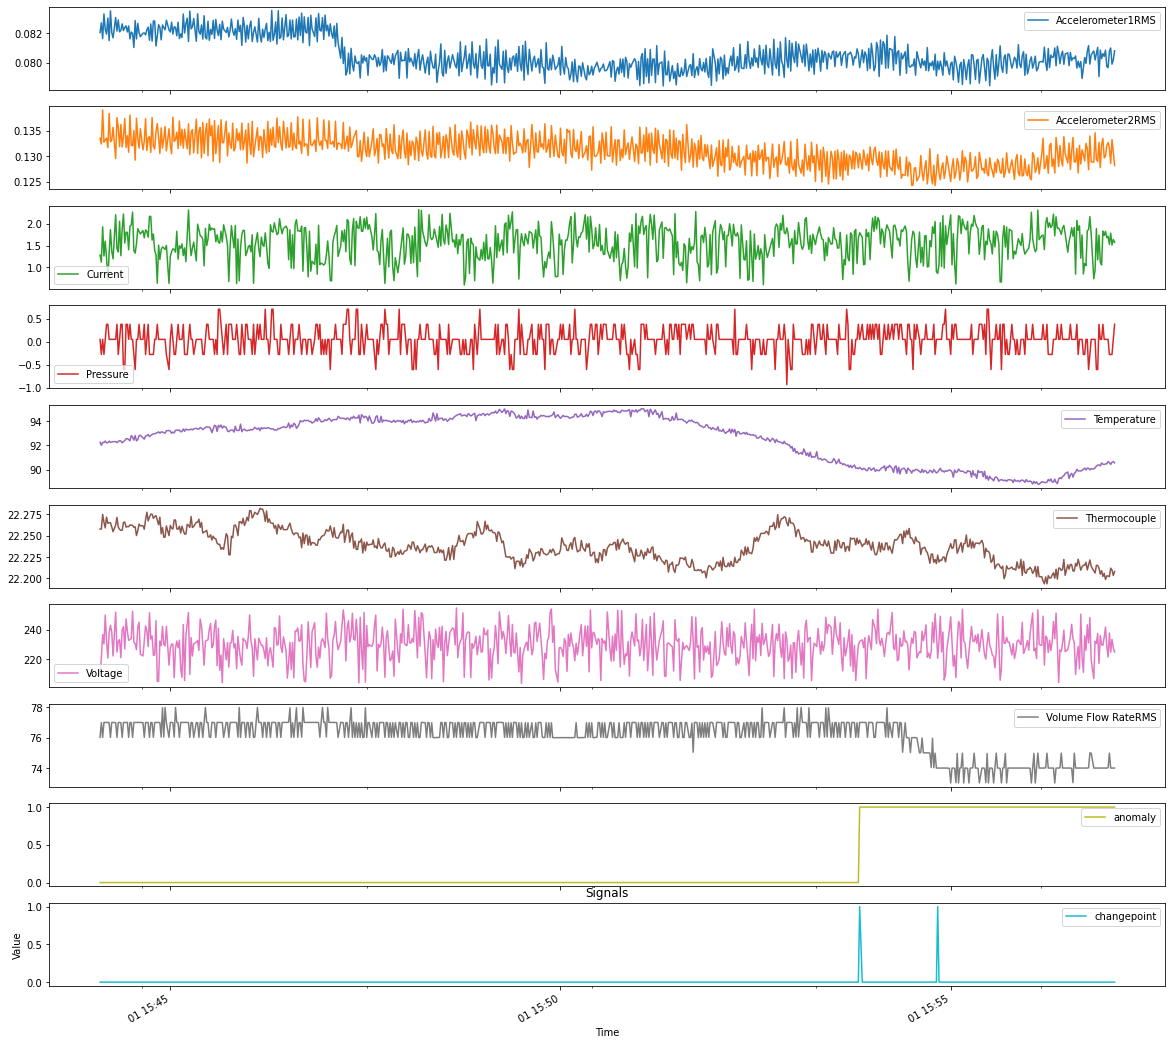

In [3]:
# random dataset visualizing
list_of_df[0].plot(figsize=(20,20),subplots=True)
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Signals')
plt.show()

SEQUENCE

In [14]:
#Redefine WINDOW_SIZE 3-6-12-24-48
WINDOW_SIZE=48
def create_sequences(values, time_steps=WINDOW_SIZE):
    output = []
    for i in range(len(values) - time_steps + 1):
        output.append(values[i : (i + time_steps)])
    return np.stack(output)  

MODEL

In [15]:
def arch(X_train):
    inputs = Input(shape=(X_train.shape[1], X_train.shape[2]))
    z = LSTM(128, return_sequences=True)(inputs)
    z = LSTM(64)(z)
    z = RepeatVector(X_train.shape[1])(z)
    z = LSTM(64, return_sequences=True)(z)
    z = LSTM(128, return_sequences=True)(z)
    outputs = TimeDistributed(Dense(X_train.shape[2]))(z)

    model = Model(inputs, outputs, name="LSTM-AE")
    model.compile(loss="mse", optimizer=keras.optimizers.Adam(), metrics=["mse"])

    #model.summary()
    return model

DATA

In [19]:

title=['Accelerometer1RMS',  'Accelerometer2RMS',  'Current', ' Pressure',
    'Temperature',  'Thermocouple',  'Voltage',  'Volume Flow RateRMS']

first_iteration=True
PREDICTION=[]
x=1
iterator=1
for df in tqdm(list_of_df,desc='Loop'):

    #input and scale data
    train=df.drop(['anomaly','changepoint'], axis=1).values[:400]
    scaler = MinMaxScaler()
    train_scaled = scaler.fit_transform(train)
    X_train=create_sequences(train_scaled)

    #model=arch(X_train)
    #history = model.fit(X_train, X_train, epochs=800, batch_size=32, verbose=0)
    model=arch(X_train)
    
    model.load_weights(filepath=f'MODEL_Saved/LSTM_AE/AE_{WINDOW_SIZE}/model_{iterator}_Win_{WINDOW_SIZE}.h5')

    #TRAIN
    Y_train = model.predict(X_train)

    #TEST
    test = df.drop(['anomaly','changepoint'], axis=1)
    X_test=scaler.transform(test)
    X_test=create_sequences(X_test)
    
    Y_test = model.predict(X_test)

    #VALIDATION
    X_val= df.drop(['anomaly','changepoint'], axis=1).values[400:450]
    X_val_scaled=scaler.transform(X_val)
    X_val_scaled=create_sequences(X_val_scaled)
    Y_val=model.predict(X_val_scaled)

    #ERROR
    mse=np.mean(np.power(X_val_scaled-Y_val,2),axis=(1,2))
    error=np.max(mse,axis=(0))
    
    error_test=np.mean(np.power(X_test-Y_test,2),axis=(1,2))

    outlier=error_test>error
    
    predi=[False for j in range(len(df))]
    for i in range(len(df)-WINDOW_SIZE):
        predi[i+WINDOW_SIZE-1]=outlier[i]
    predi=np.array(predi)
    
    PREDICTION.append(pd.Series(predi.astype(int), index=df.index))

    iterator=iterator+1


Loop:   0%|          | 0/33 [00:00<?, ?it/s]C:\Users\gioel\AppData\Roaming\Python\Python310\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(
Loop:   3%|▎         | 1/33 [00:04<02:20,  4.38s/it]C:\Users\gioel\AppData\Roaming\Python\Python310\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(
Loop:   6%|▌         | 2/33 [00:10<02:54,  5.64s/it]C:\Users\gioel\AppData\Roaming\Python\Python310\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(
Loop:   9%|▉         | 3/33 [00:16<02:48,  5.62s/it]C:\Users\gioel\AppData\Roaming\Python\Python310\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(
Loop:  12%|█▏        | 4/33 [00:22<02:49,  5.85s/it]C:\Users\gio

In [20]:
#EVALUATION METRICS
true_outlier = [df.anomaly for df in list_of_df]
metric.evalu(true_outlier,PREDICTION, metric='binary', window_time='30 sec')
print("-----------------------")

Total value: 36621
TRUE POSITIVE: 11896
TRUE NEGATIVE: 13517
FALSE POSITIVE: 10421
FALSE NEGATIVE: 787
PRECISION: 0.5330465564367971
RECALL: 0.9379484349128755
ACCURANCY: 0.693946096502007
False Alarm Rate 43.53 %
Missing Alarm Rate 6.21 %
F1 metric 0.6797714285714286
-----------------------


In [11]:

#EVALUATION METRICS
true_outlier = [df.anomaly for df in list_of_df]
metric.evalu(true_outlier,PREDICTION, metric='binary', window_time='30 sec')
print("-----------------------")

Total value: 36621
TRUE POSITIVE: 11730
TRUE NEGATIVE: 15059
FALSE POSITIVE: 8879
FALSE NEGATIVE: 953
PRECISION: 0.5691688097433161
RECALL: 0.9248600488843334
ACCURANCY: 0.7315201660249584
False Alarm Rate 37.09 %
Missing Alarm Rate 7.51 %
F1 metric 0.7046737955064281
-----------------------


score

In [6]:
title=['Accelerometer1RMS',  'Accelerometer2RMS',  'Current', ' Pressure',
    'Temperature',  'Thermocouple',  'Voltage',  'Volume Flow RateRMS']

first_iteration=True
PREDICTION=[]
x=1
iterator=1
for df in tqdm(list_of_df,desc='Loop'):

    #input and scale data
    train=df.drop(['anomaly','changepoint'], axis=1).values[:400]
    scaler = MinMaxScaler()
    train_scaled = scaler.fit_transform(train)
    X_train=create_sequences(train_scaled)

    model=arch(X_train)
    model.load_weights(filepath=f'MODEL_Saved/LSTM_AE/AE_{WINDOW_SIZE}/model_{iterator}_Win_{WINDOW_SIZE}.h5')
    X_val= df.drop(['anomaly','changepoint'], axis=1).values[400:450]
    X_val_scaled=scaler.transform(X_val)
    X_val_scaled=create_sequences(X_val_scaled)
    Y_val=model.predict(X_val_scaled)

    #ERROR
    score=np.mean(np.power(X_val_scaled-Y_val,2),axis=(1,2))

    np.save(f"./analisi_score/LSTM_AE/{iterator}.npy",score,allow_pickle=True)
    iterator=iterator+1


Loop:  12%|█▏        | 4/33 [00:10<01:10,  2.43s/it]

Loop:  15%|█▌        | 5/33 [00:13<01:12,  2.60s/it]

Loop: 100%|██████████| 33/33 [01:23<00:00,  2.52s/it]


In [5]:
import csv
header=['th_factor','method','F1','precision','recall','TP','TN','FP','FN']

mt=['IQR','MAD','STD']

with open('LSTM_AE.csv', 'w', encoding='UTF8') as f:
    writer = csv.writer(f)

    writer.writerow(header)
    thresholding_factor=[0.5,1,1.5,2]
    for k in range(3):
        for t in thresholding_factor:


            PREDICTION=[]
            TP=0
            TN=0
            FN=0
            FP=0
            iterator=1
            for df in tqdm(list_of_df):
                
                X_train = df[:400].drop(['anomaly','changepoint'], axis=1)
                X_test = df.drop(['anomaly','changepoint'], axis=1)
                X_val = df[400:450].drop(['anomaly','changepoint'], axis=1)

                scaler = MinMaxScaler(feature_range=(0,1))
                X_train_scaled = scaler.fit_transform(X_train)
                X_test_scaled  = scaler.transform(X_test)
                X_val_scaled  = scaler.transform(X_val)

                X_train=create_sequences(X_train_scaled,WINDOW_SIZE)
                X_test_scaled=create_sequences(X_test_scaled,WINDOW_SIZE)
                X_val_scaled=create_sequences(X_val_scaled,WINDOW_SIZE)

                model=arch(X_train)
                model.load_weights(filepath=f'MODEL_Saved/LSTM_AE/AE_{WINDOW_SIZE}/model_{iterator}_Win_{WINDOW_SIZE}.h5')

                Y_val=model.predict(X_val_scaled)

                score=np.mean(np.power(X_val_scaled - Y_val, 2), axis=(1,2))

                if(k==0):
                    q1, q3 = np.percentile(score, 25), np.percentile(score, 75)
                    iqr = q3 - q1
                    th = q3 + t* iqr
                if(k==1):
                    median = np.median(score)
                    mad = 1.4826 * np.median(np.abs(score - median))
                    th = median + t * mad

                if(k==2):
                    mean, std = np.mean(score), np.std(score)
                    th = mean + t * std


                Y_test=model.predict(X_test_scaled)
                score=np.mean(np.power(X_test_scaled - Y_test, 2), axis=(1,2))
                score=score>th
                true_= df['anomaly'][WINDOW_SIZE-1:]>=1
                prediction_ = score[:].astype(int)==1

                TP = TP+(true_ & prediction_).sum()   
                TN = TN+(~true_ & ~prediction_).sum()  
                FP = FP+(~true_ & prediction_).sum()    
                FN = FN+(true_ & ~prediction_).sum()    

            PREC=TP / (TP + FP)
            REC = TP/ (TP+FN)
            f1=2 * PREC * REC/(PREC + REC)
            m=['IQR','MAD','STD']
            row=[t,mt[k],f1,PREC,REC,TP,TN,FP,FN]
            writer.writerow(row)

100%|██████████| 33/33 [01:51<00:00,  3.39s/it]


In [7]:
PREDICTION=[]
iter=1
iterator=1
for df in tqdm(list_of_df):
    
    X_train = df[:400].drop(['anomaly','changepoint'], axis=1)
    X_test = df.drop(['anomaly','changepoint'], axis=1)
    X_val = df[400:450].drop(['anomaly','changepoint'], axis=1)

    scaler = MinMaxScaler(feature_range=(0,1))
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled  = scaler.transform(X_test)
    X_val_scaled  = scaler.transform(X_val)

    X_train_scaled=create_sequences(X_train_scaled,WINDOW_SIZE)
    X_test_scaled=create_sequences(X_test_scaled,WINDOW_SIZE)
    X_val_scaled=create_sequences(X_val_scaled,WINDOW_SIZE)

    
    model=arch(X_train_scaled)
    model.load_weights(filepath=f'MODEL_Saved/LSTM_AE/AE_{WINDOW_SIZE}/model_{iterator}_Win_{WINDOW_SIZE}.h5')
    Y_test = model.predict(X_test_scaled)
    Y_val=model.predict(X_val_scaled)

    error_test = np.mean(np.power(X_test_scaled - Y_test, 2), axis=(1,2))
    
    
    #np.savetxt(f'./SCORE/LSTM-AE/{iterator}.csv', error_test, delimiter=',')

    iterator=iterator+1

100%|██████████| 33/33 [01:13<00:00,  2.24s/it]
